In [1]:
import numpy as np
from numba import vectorize
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3d import Gradient
from dft3d import dft3d as dft
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-03-01

## Solid CIF file Information

In [2]:
structure_name = 'Cu-BTC'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Cu48 H96 C288 O192
num_sites: 624


In [3]:
coordinates = structure.cart_coords.T
L = np.array([l for l in structure.lattice.lengths])
L

array([26.343, 26.343, 26.343])

In [4]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11000,2.51800,63.54600
5,Zn,4.04468,27.67710,65.38000


## Fluid Information

In [5]:
# Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
epsilonff = 150.03 # kelvin
sigmaff = 3.704 # angstrom
mff = 16.043

# Create the DFT object

In [6]:
Ngrid = 64

In [7]:
DFT = dft(gridsize=np.array([Ngrid,Ngrid,Ngrid]),fmtmethod='WBI',ljmethod='MMFA')

In [8]:
DFT.Set_Geometry(L)

In [9]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
FMT : WBI
Attractive : MMFA
The grid is [64 64 64]
--- Geometry properties ---
Lx = 26.343  A
Ly = 26.343  A
Lz = 26.343  A
Vol = 18280.820975607003  A³


In [10]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [11]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 150.03  K
sigma = 3.704  A


In [12]:
kT = 300.0 # kelvin 

DFT.Set_Temperature(kT)

In [13]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 3.544  A


## Generating the External Potential

In [14]:
sigmasf = np.zeros(structure.num_sites)
epsilonsf = np.zeros(structure.num_sites)
mss = 0.0

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf[i] = 0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string])
    epsilonsf[i] = np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string])
    mss = mss + float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

In [15]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [16]:
%%time

Vext = np.zeros_like(DFT.rho)

X,Y,Z = np.meshgrid(DFT.x,DFT.y,DFT.z,indexing ='ij')
for i, site in enumerate(structure):
    R = np.sqrt((X-structure.cart_coords[i,0])**2 + (Y-structure.cart_coords[i,1])**2 + (Z-structure.cart_coords[i,2])**2)
    Vext[:] += ljpotential(R,epsilonsf[i],sigmasf[i])

del X,Y,Z,R

# np.save('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy',Vext)
# Vext[:] = np.load('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy')

DFT.Set_External_Potential(Vext)

CPU times: user 4.45 s, sys: 5.78 ms, total: 4.45 s
Wall time: 4.47 s


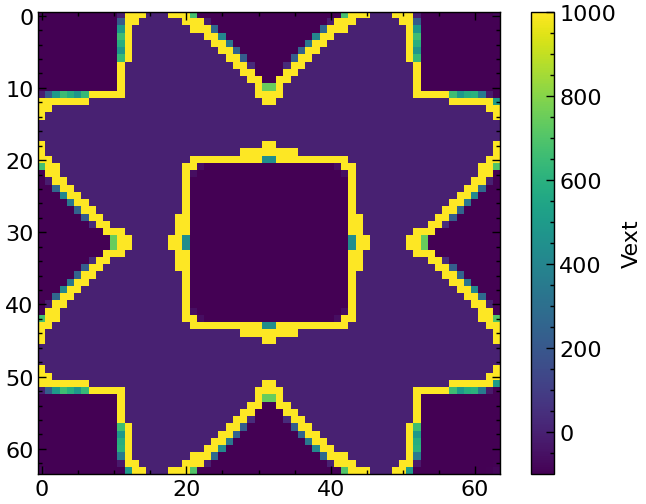

In [17]:
plt.imshow(DFT.Vext[:,:,7], cmap='viridis',vmin=-1e2,vmax=1e3)
plt.colorbar(label='Vext')
plt.show()

In [18]:
# DFT.Set_BulkDensity(1e-6)
# DFT.Set_InitialCondition()
# DFT.Update_System()

In [19]:
# DFT.GetFluidDensityInformation()

In [20]:
# from scipy.optimize import minimize, root

# sol = root(Gradient, np.log(DFT.rho), args=(DFT) , method='anderson', tol= 1e-6)

# DFT.rho[:] = np.exp(sol.x)
# DFT.Update_System()

In [21]:
# DFT.Calculate_Equilibrium(alpha0=0.15,dt=0.1,atol=1e-5,method='fire',logoutput=True)

In [22]:
# plt.imshow(DFT.rho[:,:,6], cmap='viridis')
# plt.colorbar(label='rho')
# plt.show()

In [23]:
np.log10(0.002)

-2.6989700043360187

In [24]:
rhobarray = np.power(10,np.arange(-6.5,-2.6,0.1))

In [25]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [26]:
kB = 1.380649e-23
parray = 1e-5*kB*ljeos.p(rhobarray,kT)/(1e-30)

In [27]:
parray.size

39

In [28]:
parray

array([1.30977095e-02, 1.64889491e-02, 2.07582140e-02, 2.61328164e-02,
       3.28989073e-02, 4.14167010e-02, 5.21396349e-02, 6.56384811e-02,
       8.26316852e-02, 1.04023536e-01, 1.30952181e-01, 1.64850009e-01,
       2.07519573e-01, 2.61229017e-01, 3.28831968e-01, 4.13918078e-01,
       5.21001943e-01, 6.55759969e-01, 8.25327041e-01, 1.03866761e+00,
       1.30703906e+00, 1.64456912e+00, 2.06897337e+00, 2.60244392e+00,
       3.27274526e+00, 4.11455818e+00, 5.17111651e+00, 6.49618261e+00,
       8.15640447e+00, 1.02340865e+01, 1.28303836e+01, 1.60688891e+01,
       2.00995282e+01, 2.51025888e+01, 3.12926445e+01, 3.89221207e+01,
       4.82845602e+01, 5.97189341e+01, 7.36204667e+01])

In [ ]:
%%time

Nadsarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.25,rtol=1e-2,atol=1e-4,max_iter=20,method='picard',logoutput=False)
    DFT.Calculate_Equilibrium(alpha0=0.3,dt=1.0,rtol=1e-4,atol=1e-6,method='fire',logoutput=False)

    Nadsarray[i] = DFT.Nadstot
    print(rhob,parray[i],Nadsarray[i])

3.162277660168379e-07 0.013097709546689717 0.004040826156501225
3.981071705534969e-07 0.0164889491213076 0.007505797365087309
5.011872336272714e-07 0.020758214007826556 0.014393937761399354


/home/elvis/Google Drive/Projetos em Andamento/3-DFT 3D for H2 storage in MOF/codes/PyDFTlj/examples/../src/pydftlj/dft3d.py:226: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = dphi3dnfuncWBI(self.n3)


6.309573444801917e-07 0.026132816397273925 0.20368668105626592
7.943282347242789e-07 0.032898907328027895 0.2620329636942147
9.99999999999996e-07 0.04141670100107375 0.3600912336931353
1.258925411794161e-06 0.05213963488522692 0.47140542552969267
1.5848931924611043e-06 0.06563848108120186 0.6042291020689401
1.9952623149688664e-06 0.08263168523716405 0.7662275409797026
2.5118864315095615e-06 0.1040235364365678 0.974078409691639
3.1622776601683534e-06 0.13095218136326336 1.2411747397121202
3.981071705534937e-06 0.16485000898423896 1.5607726735810028
5.011872336272673e-06 0.20751957287031195 1.975617519145718
6.309573444801865e-06 0.2612290174030991 2.495145545260488
7.943282347242723e-06 0.328831968012543 3.1536540403254945
9.999999999999877e-06 0.41391807766742017 3.946273850567252
1.2589254117941507e-05 0.5210019427404334 4.940366297846761
1.5848931924610914e-05 0.6557599685601505 5.867631220179322
1.99526231496885e-05 0.8253270410111336 6.848097901612496
2.5118864315095412e-05 1.03866

In [ ]:
Marray = mff*Nadsarray

In [ ]:
import pandas as pd
# df = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')
# gcmc_data = pd.read_pickle('gcmc_isotherm.pickle')

In [ ]:
# [p300,M300] = np.load('mof5-methane-DREIDING-kT-300.0-N-64.npy')
# [p300UFF,M300UFF] = np.load('mof5-methane-UFF-kT-300.0-N-64.npy')
# [p270UFF,M270UFF] = np.load('mof5-methane-UFF-kT-270.0-N-64.npy')

In [ ]:
# plt.scatter(df['P(bar)-300K'],df['Na(%wt)-300K'],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')
# plt.scatter(df['P(bar)-300K'],df['Na(%wt)-270K'],marker='s',edgecolors='C3',facecolors='none')
# plt.scatter(df['P(bar)-300K'],df['Na(%wt)-240K'],marker='^',edgecolors='C3',facecolors='none')

# plt.scatter(gcmc_data['Pressure [bar]'],1e-3*100*gcmc_data['Absolute adsorption [mg/g]'],marker='o',color='C3',label='GCMC')

plt.plot(parray,100*Marray/mss,'--',color='k')
# plt.plot(p270UFF,M270UFF/(1-0.01*M270UFF),'--',color='k',label='DFT-UFF')
# plt.plot(p300,M300/(1-0.01*M300),'-',color='k',label='DFT-DREIDING')
# plt.plot(p300UFF,M300UFF/(1-0.01*M300UFF),'--',color='k')
plt.legend(loc='best')
plt.xlabel('P (bar)')
plt.ylabel('$N_a$ (% w.t.)')
plt.xlim(0,60)

In [ ]:
np.save(structure_name+'-methane-'+forcefield_name+'-kT-'+str(kT)+'-N-'+str(Ngrid)+'.npy',[parray,100*Marray/(Mcr+Marray)])